In [8]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import os
import multiprocessing
from statistics import mean
import time 

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, Input, Lambda, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adadelta, Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.backend import repeat_elements, expand_dims, resize_images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

from scipy.stats import reciprocal

!pip install keras-tuner
from kerastuner.tuners import Hyperband

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import lr_scheduler
import torchvision

# Transfer Learning using ResNet-18

In [2]:
# Define the data transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), 
    transforms.Resize(224),  # Resize the input images to the size ResNet-18 expects
    transforms.ToTensor(),   # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the data
])

# Download and load the Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)

# Load a pre-trained ResNet-18 model
model  = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features

# Replace the last fully connected layer with a new one for 10 classes (Fashion MNIST has 10 classes)
model.fc = nn.Linear(num_ftrs, 10)

# Set the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


C:\Users\jense\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jense\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
device

device(type='cuda', index=0)

In [7]:



# Training loop
for epoch in range(10):
    model.train()  # Set the model to training mode
    total_correct_train = 0
    total_samples_train = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_samples_train += labels.size(0)
        total_correct_train += (predicted == labels).sum().item()

    training_accuracy = total_correct_train / total_samples_train

    # Step the learning rate scheduler
    exp_lr_scheduler.step()

    # Validation loop (after each epoch)
    model.eval()  # Set the model to evaluation mode
    total_correct_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            _, predicted = torch.max(val_outputs, 1)
            total_samples_val += val_labels.size(0)
            total_correct_val += (predicted == val_labels).sum().item()

    validation_accuracy = total_correct_val / total_samples_val

    print(f'Epoch [{epoch + 1}/10]: Training Accuracy = {training_accuracy * 100:.2f}%, Validation Accuracy = {validation_accuracy * 100:.2f}%')

# Your model is now trained and validated with a learning rate schedule

# Now, your model's last fully connected layer is fine-tuned on the Fashion MNIST dataset.

Epoch [1/10]: Training Accuracy = 76.68%, Validation Accuracy = 82.58%
Epoch [2/10]: Training Accuracy = 82.84%, Validation Accuracy = 83.95%
Epoch [3/10]: Training Accuracy = 83.75%, Validation Accuracy = 84.47%
Epoch [4/10]: Training Accuracy = 84.59%, Validation Accuracy = 85.45%
Epoch [5/10]: Training Accuracy = 84.81%, Validation Accuracy = 85.91%
Epoch [6/10]: Training Accuracy = 85.32%, Validation Accuracy = 86.04%
Epoch [7/10]: Training Accuracy = 85.53%, Validation Accuracy = 86.18%
Epoch [8/10]: Training Accuracy = 85.85%, Validation Accuracy = 86.33%
Epoch [9/10]: Training Accuracy = 85.80%, Validation Accuracy = 86.22%
Epoch [10/10]: Training Accuracy = 85.98%, Validation Accuracy = 86.29%


In [8]:
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

model.eval()  # Set the model to evaluation mode
total_correct_test = 0
total_samples_test = 0

with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, predicted = torch.max(test_outputs, 1)
        total_samples_test += test_labels.size(0)
        total_correct_test += (predicted == test_labels).sum().item()

test_accuracy = total_correct_test / total_samples_test
print(f'Test Accuracy = {test_accuracy * 100:.2f}%')

Test Accuracy = 85.99%


In [16]:
#save model
torch.save(model, 'trained_model(last_layer).pth')

# #load model
# model = torch.load('trained_model(last_layer).pth', map_location=torch.device('cpu'))

## ResNet-18 model with fully-connected layer + 1 layer retuned

In [21]:
#trying with training more than one layer
# Load a pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
# Specify the layers to train
for name, param in model.named_parameters():
    if "fc" in name or "layer4" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_ftrs = model.fc.in_features

# Replace the last fully connected layer with a new one for 10 classes (Fashion MNIST has 10 classes)
model.fc = nn.Linear(num_ftrs, 10)

# Set the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop
for epoch in range(10):
    model.train()  # Set the model to training mode
    total_correct_train = 0
    total_samples_train = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_samples_train += labels.size(0)
        total_correct_train += (predicted == labels).sum().item()

    training_accuracy = total_correct_train / total_samples_train

    # Step the learning rate scheduler
    exp_lr_scheduler.step()

    # Validation loop (after each epoch)
    model.eval()  # Set the model to evaluation mode
    total_correct_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            _, predicted = torch.max(val_outputs, 1)
            total_samples_val += val_labels.size(0)
            total_correct_val += (predicted == val_labels).sum().item()

    validation_accuracy = total_correct_val / total_samples_val

    print(f'Epoch [{epoch + 1}/10]: Training Accuracy = {training_accuracy * 100:.2f}%, Validation Accuracy = {validation_accuracy * 100:.2f}%')

# Your model is now trained and validated with a learning rate schedule

# Now, your model's last fully connected layer is fine-tuned on the Fashion MNIST dataset.

Epoch [1/10]: Training Accuracy = 84.05%, Validation Accuracy = 89.73%
Epoch [2/10]: Training Accuracy = 90.62%, Validation Accuracy = 91.27%
Epoch [3/10]: Training Accuracy = 92.56%, Validation Accuracy = 91.98%
Epoch [4/10]: Training Accuracy = 94.13%, Validation Accuracy = 92.47%
Epoch [5/10]: Training Accuracy = 95.27%, Validation Accuracy = 92.62%
Epoch [6/10]: Training Accuracy = 96.47%, Validation Accuracy = 92.73%
Epoch [7/10]: Training Accuracy = 97.52%, Validation Accuracy = 92.49%
Epoch [8/10]: Training Accuracy = 98.53%, Validation Accuracy = 92.80%
Epoch [9/10]: Training Accuracy = 98.71%, Validation Accuracy = 92.83%
Epoch [10/10]: Training Accuracy = 98.86%, Validation Accuracy = 92.80%


In [22]:
torch.save(model, 'trained_model(4thblkretrain).pth')
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

model.eval()  # Set the model to evaluation mode
total_correct_test = 0
total_samples_test = 0

with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, predicted = torch.max(test_outputs, 1)
        total_samples_test += test_labels.size(0)
        total_correct_test += (predicted == test_labels).sum().item()

test_accuracy = total_correct_test / total_samples_test
print(f'Test Accuracy = {test_accuracy * 100:.2f}%')

Test Accuracy = 92.23%


## ResNet-18 model with fully-connected layer + 2 layer retuned

In [15]:
#trying with training more than one layer
# Load a pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
# Specify the layers to train
for name, param in model.named_parameters():
    if "fc" in name or "layer4" in name or "layer3" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_ftrs = model.fc.in_features

# Replace the last fully connected layer with a new one for 10 classes (Fashion MNIST has 10 classes)
model.fc = nn.Linear(num_ftrs, 10)

# Set the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop
for epoch in range(10):
    model.train()  # Set the model to training mode
    total_correct_train = 0
    total_samples_train = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_samples_train += labels.size(0)
        total_correct_train += (predicted == labels).sum().item()

    training_accuracy = total_correct_train / total_samples_train

    # Step the learning rate scheduler
    exp_lr_scheduler.step()

    # Validation loop (after each epoch)
    model.eval()  # Set the model to evaluation mode
    total_correct_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            _, predicted = torch.max(val_outputs, 1)
            total_samples_val += val_labels.size(0)
            total_correct_val += (predicted == val_labels).sum().item()

    validation_accuracy = total_correct_val / total_samples_val

    print(f'Epoch [{epoch + 1}/10]: Training Accuracy = {training_accuracy * 100:.2f}%, Validation Accuracy = {validation_accuracy * 100:.2f}%')

# Your model is now trained and validated with a learning rate schedule

# Now, your model's last fully connected layer is fine-tuned on the Fashion MNIST dataset.

Epoch [1/10]: Training Accuracy = 85.64%, Validation Accuracy = 91.03%
Epoch [2/10]: Training Accuracy = 92.36%, Validation Accuracy = 91.73%
Epoch [3/10]: Training Accuracy = 94.20%, Validation Accuracy = 93.12%
Epoch [4/10]: Training Accuracy = 95.77%, Validation Accuracy = 92.90%
Epoch [5/10]: Training Accuracy = 97.09%, Validation Accuracy = 93.13%
Epoch [6/10]: Training Accuracy = 98.26%, Validation Accuracy = 93.23%
Epoch [7/10]: Training Accuracy = 99.00%, Validation Accuracy = 93.35%
Epoch [8/10]: Training Accuracy = 99.66%, Validation Accuracy = 93.39%
Epoch [9/10]: Training Accuracy = 99.76%, Validation Accuracy = 93.57%
Epoch [10/10]: Training Accuracy = 99.79%, Validation Accuracy = 93.49%


In [16]:
torch.save(model, 'trained_model(3and4th layer).pth')
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

model.eval()  # Set the model to evaluation mode
total_correct_test = 0
total_samples_test = 0

with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, predicted = torch.max(test_outputs, 1)
        total_samples_test += test_labels.size(0)
        total_correct_test += (predicted == test_labels).sum().item()

test_accuracy = total_correct_test / total_samples_test
print(f'Test Accuracy = {test_accuracy * 100:.2f}%')

Test Accuracy = 93.07%


## ResNet-18 model with fully-connected layer + 3 layer retuned

In [17]:
#trying with training more than one layer
# Load a pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
# Specify the layers to train
for name, param in model.named_parameters():
    if "fc" in name or "layer4" in name or "layer3" in name or "layer2" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_ftrs = model.fc.in_features

# Replace the last fully connected layer with a new one for 10 classes (Fashion MNIST has 10 classes)
model.fc = nn.Linear(num_ftrs, 10)

# Set the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop
for epoch in range(10):
    model.train()  # Set the model to training mode
    total_correct_train = 0
    total_samples_train = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_samples_train += labels.size(0)
        total_correct_train += (predicted == labels).sum().item()

    training_accuracy = total_correct_train / total_samples_train

    # Step the learning rate scheduler
    exp_lr_scheduler.step()

    # Validation loop (after each epoch)
    model.eval()  # Set the model to evaluation mode
    total_correct_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            _, predicted = torch.max(val_outputs, 1)
            total_samples_val += val_labels.size(0)
            total_correct_val += (predicted == val_labels).sum().item()

    validation_accuracy = total_correct_val / total_samples_val

    print(f'Epoch [{epoch + 1}/10]: Training Accuracy = {training_accuracy * 100:.2f}%, Validation Accuracy = {validation_accuracy * 100:.2f}%')

# Your model is now trained and validated with a learning rate schedule

# Now, your model's last fully connected layer is fine-tuned on the Fashion MNIST dataset.

Epoch [1/10]: Training Accuracy = 86.43%, Validation Accuracy = 91.53%
Epoch [2/10]: Training Accuracy = 92.68%, Validation Accuracy = 93.14%
Epoch [3/10]: Training Accuracy = 94.55%, Validation Accuracy = 93.58%
Epoch [4/10]: Training Accuracy = 95.89%, Validation Accuracy = 93.53%
Epoch [5/10]: Training Accuracy = 97.15%, Validation Accuracy = 93.84%
Epoch [6/10]: Training Accuracy = 98.20%, Validation Accuracy = 93.84%
Epoch [7/10]: Training Accuracy = 98.93%, Validation Accuracy = 93.85%
Epoch [8/10]: Training Accuracy = 99.66%, Validation Accuracy = 94.17%
Epoch [9/10]: Training Accuracy = 99.78%, Validation Accuracy = 94.21%
Epoch [10/10]: Training Accuracy = 99.83%, Validation Accuracy = 94.36%


In [18]:
torch.save(model, 'trained_model(234thlayer).pth')
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

model.eval()  # Set the model to evaluation mode
total_correct_test = 0
total_samples_test = 0

with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, predicted = torch.max(test_outputs, 1)
        total_samples_test += test_labels.size(0)
        total_correct_test += (predicted == test_labels).sum().item()

test_accuracy = total_correct_test / total_samples_test
print(f'Test Accuracy = {test_accuracy * 100:.2f}%')

Test Accuracy = 93.46%


## ResNet-18 model with fully-connected layer + 4 layer retuned

In [9]:
#trying with training more than one layer
# Load a pre-trained ResNet-18 model
st = time.time()
model = models.resnet18(pretrained=True)
# Specify the layers to train
for name, param in model.named_parameters():
    if "fc" in name or "layer4"  in name or "layer3"  in name or "layer2"  in name or "layer1" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_ftrs = model.fc.in_features

# Replace the last fully connected layer with a new one for 10 classes (Fashion MNIST has 10 classes)
model.fc = nn.Linear(num_ftrs, 10)

# Set the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop
for epoch in range(10):
    model.train()  # Set the model to training mode
    total_correct_train = 0
    total_samples_train = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_samples_train += labels.size(0)
        total_correct_train += (predicted == labels).sum().item()

    training_accuracy = total_correct_train / total_samples_train

    # Step the learning rate scheduler
    exp_lr_scheduler.step()

    # Validation loop (after each epoch)
    model.eval()  # Set the model to evaluation mode
    total_correct_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            _, predicted = torch.max(val_outputs, 1)
            total_samples_val += val_labels.size(0)
            total_correct_val += (predicted == val_labels).sum().item()

    validation_accuracy = total_correct_val / total_samples_val

    print(f'Epoch [{epoch + 1}/10]: Training Accuracy = {training_accuracy * 100:.2f}%, Validation Accuracy = {validation_accuracy * 100:.2f}%')

# Your model is now trained and validated with a learning rate schedule

# Now, your model's last fully connected layer is fine-tuned on the Fashion MNIST dataset.

et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Epoch [1/10]: Training Accuracy = 86.60%, Validation Accuracy = 91.91%
Epoch [2/10]: Training Accuracy = 92.76%, Validation Accuracy = 93.05%
Epoch [3/10]: Training Accuracy = 94.41%, Validation Accuracy = 93.96%
Epoch [4/10]: Training Accuracy = 95.62%, Validation Accuracy = 94.08%
Epoch [5/10]: Training Accuracy = 96.71%, Validation Accuracy = 94.47%
Epoch [6/10]: Training Accuracy = 97.60%, Validation Accuracy = 94.43%
Epoch [7/10]: Training Accuracy = 98.35%, Validation Accuracy = 94.01%
Epoch [8/10]: Training Accuracy = 99.36%, Validation Accuracy = 94.45%
Epoch [9/10]: Training Accuracy = 99.56%, Validation Accuracy = 94.63%
Epoch [10/10]: Training Accuracy = 99.67%, Validation Accuracy = 94.55%
Execution time: 1001.3237609863281 seconds


In [10]:
torch.save(model, 'trained_model(1234thlayer).pth')
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

model.eval()  # Set the model to evaluation mode
total_correct_test = 0
total_samples_test = 0

with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, predicted = torch.max(test_outputs, 1)
        total_samples_test += test_labels.size(0)
        total_correct_test += (predicted == test_labels).sum().item()

test_accuracy = total_correct_test / total_samples_test
print(f'Test Accuracy = {test_accuracy * 100:.2f}%')

Test Accuracy = 94.10%


## ResNet-18 model with whole model retuned

In [30]:
#trying with training more than one layer (all layers)
# Load a pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
# total_layers = len(list(model.parameters()))
# start_layer = total_layers - 50
# for i, param in enumerate(model.parameters()):
#     if i >= start_layer:
#         param.requires_grad = True
#     else:
#         param.requires_grad = False
num_ftrs = model.fc.in_features

# Replace the last fully connected layer with a new one for 10 classes (Fashion MNIST has 10 classes)
model.fc = nn.Linear(num_ftrs, 10)

# Set the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop
for epoch in range(10):
    model.train()  # Set the model to training mode
    total_correct_train = 0
    total_samples_train = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_samples_train += labels.size(0)
        total_correct_train += (predicted == labels).sum().item()

    training_accuracy = total_correct_train / total_samples_train

    # Step the learning rate scheduler
    exp_lr_scheduler.step()

    # Validation loop (after each epoch)
    model.eval()  # Set the model to evaluation mode
    total_correct_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            _, predicted = torch.max(val_outputs, 1)
            total_samples_val += val_labels.size(0)
            total_correct_val += (predicted == val_labels).sum().item()

    validation_accuracy = total_correct_val / total_samples_val

    print(f'Epoch [{epoch + 1}/10]: Training Accuracy = {training_accuracy * 100:.2f}%, Validation Accuracy = {validation_accuracy * 100:.2f}%')

# Your model is now trained and validated with a learning rate schedule

# Now, your model's last fully connected layer is fine-tuned on the Fashion MNIST dataset.

Epoch [1/10]: Training Accuracy = 86.91%, Validation Accuracy = 90.78%
Epoch [2/10]: Training Accuracy = 92.67%, Validation Accuracy = 92.71%
Epoch [3/10]: Training Accuracy = 94.34%, Validation Accuracy = 93.52%
Epoch [4/10]: Training Accuracy = 95.48%, Validation Accuracy = 93.78%
Epoch [5/10]: Training Accuracy = 96.34%, Validation Accuracy = 93.76%
Epoch [6/10]: Training Accuracy = 97.24%, Validation Accuracy = 94.08%
Epoch [7/10]: Training Accuracy = 98.09%, Validation Accuracy = 94.09%
Epoch [8/10]: Training Accuracy = 99.22%, Validation Accuracy = 94.37%
Epoch [9/10]: Training Accuracy = 99.38%, Validation Accuracy = 94.39%
Epoch [10/10]: Training Accuracy = 99.52%, Validation Accuracy = 94.31%


In [31]:
torch.save(model, 'trained_model(alllayer).pth')
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

model.eval()  # Set the model to evaluation mode
total_correct_test = 0
total_samples_test = 0

with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, predicted = torch.max(test_outputs, 1)
        total_samples_test += test_labels.size(0)
        total_correct_test += (predicted == test_labels).sum().item()

test_accuracy = total_correct_test / total_samples_test
print(f'Test Accuracy = {test_accuracy * 100:.2f}%')

Test Accuracy = 93.86%


## Comparisons of all ResNet-18 models with different level of tuning 

In [13]:
test_accuracy = [85.99,92.23,93.07,93.46,94.10,93.86]
Test_batches = ['fc layer', 'fc+1', 'fc+2', 'fc+3', 'fc+4','all layers']
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame({ 'Test Batches': Test_batches,'Test Accuracy': test_accuracy})

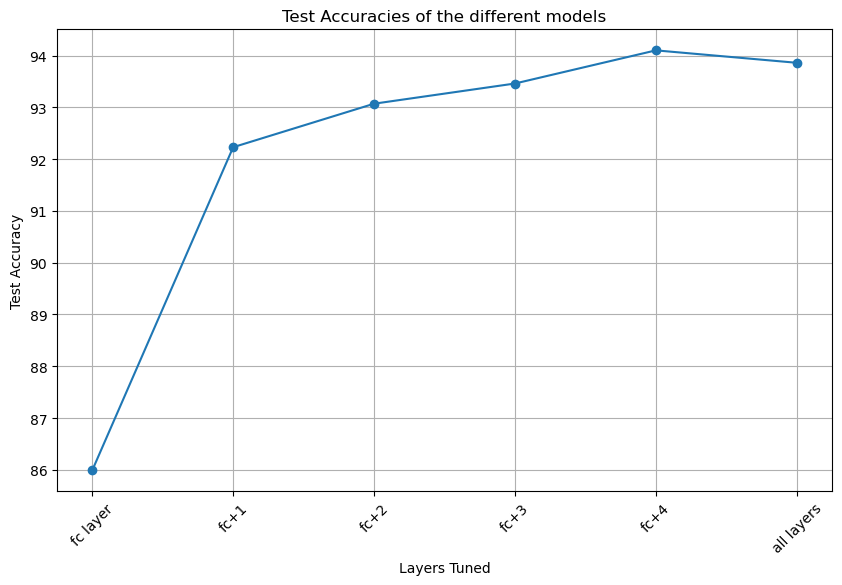

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(df['Test Batches'], df['Test Accuracy'], marker='o', linestyle='-')
plt.xticks(rotation=45)
plt.xlabel('Layers Tuned')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracies of the different models')
plt.grid()
plt.show()


## ResNet-18 model with Data Augmentation


In [4]:
def mixup(imgs, labels, alpha):
  lam = np.random.beta(alpha,alpha)
  index = torch.randperm(len(imgs))
  shuffled_imgs = imgs[index]
  shuffled_labels = labels[index]
  new_imgs = lam*imgs + (1-lam)*shuffled_imgs

  return new_imgs, shuffled_labels, lam 

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    return new_data, shuffled_target, lam

In [61]:
#trying with data augmentation

cutmixalpha = 1.0
mixupalpha = 0.2

from torchvision.transforms import v2
import numpy as np



train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

#trying with training more than one layer
# Load a pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
# Specify the layers to train
for name, param in model.named_parameters():
    if "fc" in name or "layer4" in name or "layer3" in name or "layer2" in name or "layer1" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_ftrs = model.fc.in_features

# Replace the last fully connected layer with a new one for 10 classes (Fashion MNIST has 10 classes)
model.fc = nn.Linear(num_ftrs, 10)

# Set the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop
for epoch in range(10):
    model.train()  # Set the model to training mode
    total_correct_train = 0
    total_samples_train = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        if np.random.rand() > 0.5:  # Adjust the probability as needed
            augmented_inputs, labels, lam = cutmix(inputs, labels, cutmixalpha)
        else:
            augmented_inputs, labels, lam = mixup(inputs, labels, mixupalpha)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(augmented_inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_samples_train += labels.size(0)
        total_correct_train += (predicted == labels).sum().item()

    training_accuracy = total_correct_train / total_samples_train

    # Step the learning rate scheduler
    exp_lr_scheduler.step()

    # Validation loop (after each epoch)
    model.eval()  # Set the model to evaluation mode
    total_correct_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            _, predicted = torch.max(val_outputs, 1)
            total_samples_val += val_labels.size(0)
            total_correct_val += (predicted == val_labels).sum().item()

    validation_accuracy = total_correct_val / total_samples_val

    print(f'Epoch [{epoch + 1}/10]: Training Accuracy = {training_accuracy * 100:.2f}%, Validation Accuracy = {validation_accuracy * 100:.2f}%')

# Your model is now trained and validated with a learning rate schedule

# Now, your model's last fully connected layer is fine-tuned on the Fashion MNIST dataset.

Epoch [1/10]: Training Accuracy = 44.36%, Validation Accuracy = 84.33%
Epoch [2/10]: Training Accuracy = 51.19%, Validation Accuracy = 85.94%
Epoch [3/10]: Training Accuracy = 57.13%, Validation Accuracy = 87.99%
Epoch [4/10]: Training Accuracy = 58.18%, Validation Accuracy = 89.85%
Epoch [5/10]: Training Accuracy = 59.01%, Validation Accuracy = 90.30%
Epoch [6/10]: Training Accuracy = 61.69%, Validation Accuracy = 90.95%
Epoch [7/10]: Training Accuracy = 60.35%, Validation Accuracy = 91.11%
Epoch [8/10]: Training Accuracy = 62.38%, Validation Accuracy = 91.75%
Epoch [9/10]: Training Accuracy = 63.50%, Validation Accuracy = 92.27%
Epoch [10/10]: Training Accuracy = 63.28%, Validation Accuracy = 92.05%


In [62]:
torch.save(model, 'dataaugmentation.pth')
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

model.eval()  # Set the model to evaluation mode
total_correct_test = 0
total_samples_test = 0

with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, predicted = torch.max(test_outputs, 1)
        total_samples_test += test_labels.size(0)
        total_correct_test += (predicted == test_labels).sum().item()

test_accuracy = total_correct_test / total_samples_test
print(f'Test Accuracy = {test_accuracy * 100:.2f}%')

Test Accuracy = 91.06%


### ResNet-18 Model with data augmentation with more epoch training cycles

In [5]:
#trying with data augmentation

cutmixalpha = 1.0
mixupalpha = 0.2

from torchvision.transforms import v2
import numpy as np



train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

#trying with training more than one layer
# Load a pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
# Specify the layers to train
for name, param in model.named_parameters():
    if "fc" in name or "layer4" in name or "layer3" in name or "layer2" in name or "layer1" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_ftrs = model.fc.in_features

# Replace the last fully connected layer with a new one for 10 classes (Fashion MNIST has 10 classes)
model.fc = nn.Linear(num_ftrs, 10)

# Set the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop
for epoch in range(24):
    model.train()  # Set the model to training mode
    total_correct_train = 0
    total_samples_train = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        if np.random.rand() > 0.5:  # Adjust the probability as needed
            augmented_inputs, labels, lam = cutmix(inputs, labels, cutmixalpha)
        else:
            augmented_inputs, labels, lam = mixup(inputs, labels, mixupalpha)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(augmented_inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_samples_train += labels.size(0)
        total_correct_train += (predicted == labels).sum().item()

    training_accuracy = total_correct_train / total_samples_train

    # Step the learning rate scheduler
    exp_lr_scheduler.step()

    # Validation loop (after each epoch)
    model.eval()  # Set the model to evaluation mode
    total_correct_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            _, predicted = torch.max(val_outputs, 1)
            total_samples_val += val_labels.size(0)
            total_correct_val += (predicted == val_labels).sum().item()

    validation_accuracy = total_correct_val / total_samples_val

    print(f'Epoch [{epoch + 1}/24]: Training Accuracy = {training_accuracy * 100:.2f}%, Validation Accuracy = {validation_accuracy * 100:.2f}%')

# Your model is now trained and validated with a learning rate schedule

# Now, your model's last fully connected layer is fine-tuned on the Fashion MNIST dataset.

Epoch [1/24]: Training Accuracy = 40.72%, Validation Accuracy = 85.22%
Epoch [2/24]: Training Accuracy = 50.51%, Validation Accuracy = 84.15%
Epoch [3/24]: Training Accuracy = 55.11%, Validation Accuracy = 86.75%
Epoch [4/24]: Training Accuracy = 54.30%, Validation Accuracy = 87.56%
Epoch [5/24]: Training Accuracy = 58.74%, Validation Accuracy = 89.72%
Epoch [6/24]: Training Accuracy = 59.92%, Validation Accuracy = 89.92%
Epoch [7/24]: Training Accuracy = 60.45%, Validation Accuracy = 91.04%
Epoch [8/24]: Training Accuracy = 63.00%, Validation Accuracy = 92.03%
Epoch [9/24]: Training Accuracy = 62.59%, Validation Accuracy = 91.62%
Epoch [10/24]: Training Accuracy = 61.91%, Validation Accuracy = 92.16%
Epoch [11/24]: Training Accuracy = 62.44%, Validation Accuracy = 91.66%
Epoch [12/24]: Training Accuracy = 62.44%, Validation Accuracy = 91.96%
Epoch [13/24]: Training Accuracy = 62.07%, Validation Accuracy = 92.09%
Epoch [14/24]: Training Accuracy = 62.36%, Validation Accuracy = 92.13%
E

In [6]:
torch.save(model, 'dataaugmentationmoreepoch.pth')
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

model.eval()  # Set the model to evaluation mode
total_correct_test = 0
total_samples_test = 0

with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, predicted = torch.max(test_outputs, 1)
        total_samples_test += test_labels.size(0)
        total_correct_test += (predicted == test_labels).sum().item()

test_accuracy = total_correct_test / total_samples_test
print(f'Test Accuracy = {test_accuracy * 100:.2f}%')

Test Accuracy = 91.54%
